# Building Input Pipeline for train and test data

In [1]:
import numpy as np 
import pandas as pd
import xml.etree.ElementTree as ET
from PIL import Image
import cv2
import os
import xml.dom.minidom
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D

Populating the interactive namespace from numpy and matplotlib


2022-12-10 20:17:58.848283: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#source :- https://www.tensorflow.org/api_docs/python/tf/data/Dataset

height , width = 1024 , 1024 #size to which input image needs to resize

def mapping(file_path):

  table_path = tf.strings.regex_replace(file_path, 'marmots_usuals', 'marmot_table')
  column_path = tf.strings.regex_replace(file_path, 'marmots_usuals', 'marmot_column')

  table_path = tf.strings.regex_replace(table_path, '.jpeg', '.bmp_table.jpeg')
  column_path = tf.strings.regex_replace(column_path, '.jpeg', '.bmp_col.jpeg')
  

  #reading  , resizing and normalizing for image data
  images = tf.io.read_file(file_path)
  images = tf.image.decode_jpeg(images, channels=3) #Decode a JPEG-encoded image to a uint8 tensor
  images = tf.cast(images, tf.float32) / 255.0 # normalizing image

  #reading  , resizing and normalizing for table mask data
  table_mask = tf.io.read_file(table_path)
  table_mask = tf.image.decode_jpeg(table_mask, channels=1) 
  table_mask = tf.image.resize(table_mask, [height, width]) #resizing image to input shape of model
  table_mask = tf.cast(table_mask, tf.float32) / 255.0 

  #reading  , resizing and normalizing for column mask data
  column_mask = tf.io.read_file(column_path)
  column_mask = tf.image.decode_jpeg(column_mask, channels=1) 
  column_mask = tf.image.resize(column_mask, [height, width]) 
  column_mask = tf.cast(column_mask, tf.float32) / 255.0 

  return images, {"table_mask" : table_mask, "column_mask" : column_mask }

def data_pipeline(dataset, input , batch_size = 1):
  #how many parallel call need to be done , so left tensor to decide
  autotune = tf.data.experimental.AUTOTUNE

  if input == 'train':
    #length of file list
    total_size = len(list(dataset))

    #proportion of file to be fetched for train 
    proportion = 0.9
    input_data_size = int(proportion * total_size)
    
    #fetching data for input
    input_data = dataset.take(input_data_size)
    
    #mapping file from input data
    input_data = input_data.map(mapping,num_parallel_calls=autotune)
    train_data = input_data

    #kepping track of inital loaded data in the memory to speed up the the process for next iteration 
    input_data = input_data.cache()

    #Randomly shuffles the elements for the given dataset
    buffer_size =  input_data_size # randomly samples elements from this buffer, replacing the selected elements with new elements
    input_data = input_data.shuffle(buffer_size)

    #creating input file in batch 
    input_data = input_data.batch(batch_size)

    # to re-initialize the input_data
    input_data = input_data.repeat()

    #delivers data for the next step before the current step has finished
    input_data = input_data.prefetch(buffer_size=autotune)

    return input_data , train_data

  else:
    #length of file list
    total_size = len(list(dataset))

    #proportion of file to be fetched for train and test
    proportion = 0.9
    input_data_size = int(proportion * total_size)
    
    #fetching data for input
    input_data = dataset.skip(input_data_size)
    
    #mapping file from input data
    input_data = input_data.map(mapping,num_parallel_calls=autotune)
    test_data = input_data

    #Randomly shuffles the elements for the given dataset
    buffer_size =  input_data_size 
    input_data = input_data.shuffle(buffer_size)

    #creating input file in batch 
    input_data = input_data.batch(batch_size)

    return input_data , test_data



In [3]:
#Create a source dataset from given  input data
#dataset = tf.data.Dataset.list_files("/content/content/Shareddrives/my_drive/input/CHK1/data/marmots_1024/*.jpeg")
dataset = tf.data.Dataset.list_files("/Users/bala/Documents/Table_extraction-main/data/marmots_usuals/*.jpeg")

train_dataloader , train_data = data_pipeline(dataset, 'train' , batch_size = 1)
test_dataloader , test_data= data_pipeline(dataset, 'test' , batch_size = 1)


2022-12-10 20:18:58.267680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


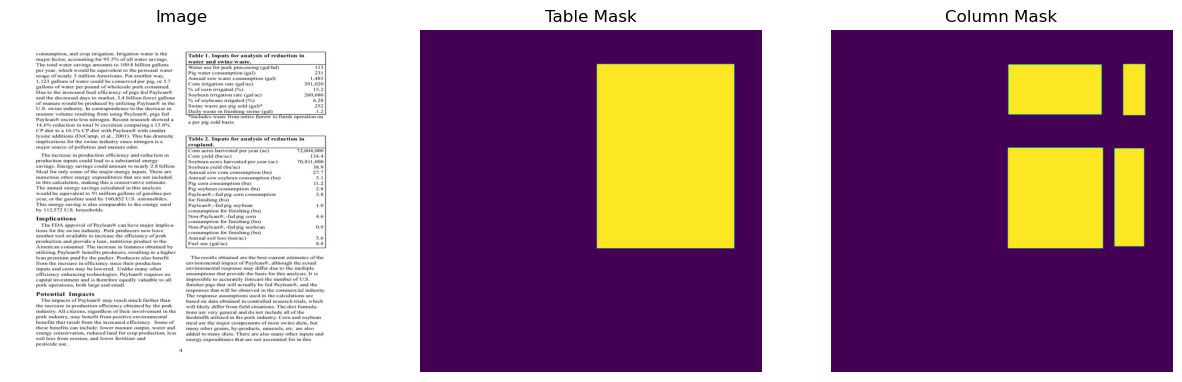

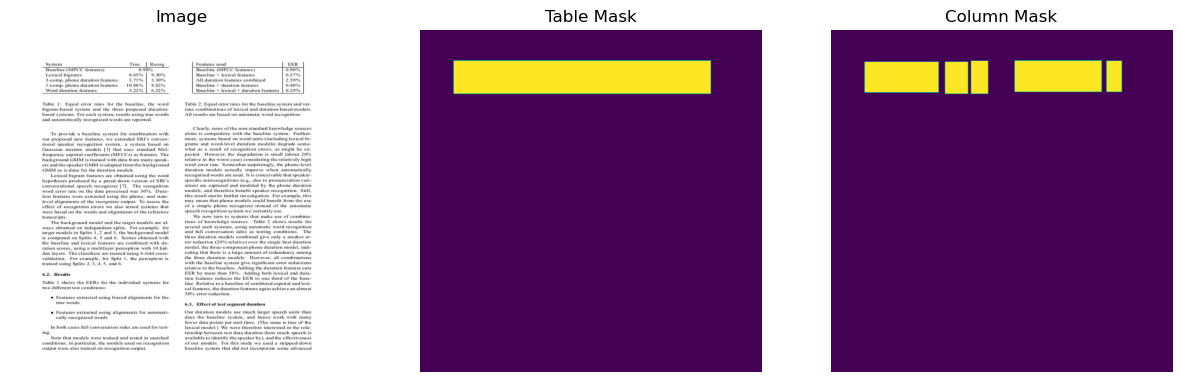

In [4]:
number = 2
for image, mask  in test_data.take(number):
  plt.figure(figsize=(15, 15))
  lists = [image, mask['table_mask'], mask['column_mask']]
  title = ['Image', 'Table Mask', 'Column Mask']         
  for i in range(len(lists)):
    plt.subplot(1, len(lists), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(lists[i]))
    plt.axis('off')
  plt.show()         

In [5]:
#input size for all image should be 1024 * 1024 with three channels
inputShape = (1024, 1024, 3)
inputs = Input(shape=inputShape, name='input')

#importing  pre trained VGG19 model till to bottle neck
vgg_19=tf.keras.applications.VGG19(input_tensor=inputs,include_top=False, weights='imagenet', pooling=None, classes=1000)

#addding 2 (1 * 1) convolutional layers followed by dropot eith 80%
x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv1')(vgg_19.output)
x = Dropout(0.8, name='block6_dropout1')(x)
x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv2')(x)
x = Dropout(0.8, name = 'block6_dropout2')(x)


#taking 3rd and 4th maxpool layer from vgg_19 for decoders
block3_pool=vgg_19.get_layer('block3_pool').output
block4_pool=vgg_19.get_layer('block4_pool').output

80134624/80134624 [==============================] - 13s 0us/step


In [6]:
class table_decoder(tf.keras.layers.Layer):
    def __init__(self, name="table_mask"):
        super().__init__(name=name)
        self.conv1 = Conv2D(filters =512,kernel_size = (1, 1), activation = 'relu')
        self.upsample1 = UpSampling2D(size=(2, 2))
        self.upsample2 = UpSampling2D(size=(2, 2))
        self.upsample3 = UpSampling2D(size=(2,2))
        self.upsample4 = UpSampling2D(size=(2,2))
        self.convtraspose = tf.keras.layers.Conv2DTranspose(3, 3, strides=2,padding='same')

        
    def call(self, X):
      input , pool_3, pool_4 = X[0] , X[1], X[2]


      result = self.conv1(input)
      result = self.upsample1(result)
      result = Concatenate()([result,pool_4])
      result = self.upsample2(result)
      result = Concatenate()([result,pool_3])
      result = self.upsample3(result)
      result = self.upsample4(result)
      result = self.convtraspose(result)

      return result


In [7]:
class column_decoder(tf.keras.layers.Layer):
    def __init__(self, name="column_mask"):
        super().__init__(name=name)
        self.conv1 = Conv2D(filters =512,kernel_size = (1, 1), activation = 'relu')
        self.drop = Dropout(0.8)
        self.conv2 = Conv2D(filters =512,kernel_size = (1, 1), activation = 'relu')
        self.upsample1 = UpSampling2D(size=(2, 2))
        self.upsample2 = UpSampling2D(size=(2, 2))
        self.upsample3 = UpSampling2D(size=(2,2))
        self.upsample4 = UpSampling2D(size=(2,2))
        self.convtraspose = tf.keras.layers.Conv2DTranspose(3, 3, strides=2,padding='same', name='column_mask')
        
    def call(self, X):
      input , pool_3, pool_4 = X[0] , X[1], X[2]

      result = self.conv1(input)
      result = self.drop(result)
      result = self.conv2(result)
      result = self.upsample1(result)
      result = Concatenate()([result,pool_4])
      result = self.upsample2(result)
      result = Concatenate()([result,pool_3])
      result = self.upsample3(result)
      result = self.upsample4(result)
      result = self.convtraspose(result)
      return result

In [8]:
encoder_result = [x,block3_pool,block4_pool]

Table_Decoder = table_decoder()
Column_Decoder = column_decoder()

output1 = Table_Decoder(encoder_result)
output2 = Column_Decoder(encoder_result)

In [9]:
model = Model(inputs=inputs,outputs=[output1, output2],name="tablenet")

In [15]:
import pydot
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
!pip install pydot

In [16]:
model.summary()

Model: "tablenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, 1024, 1024,   1792        ['input[0][0]']                  
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, 1024, 1024,   36928       ['block1_conv1[0][0]']           
                                64)                                                        

In [17]:
losses = {
    "table_mask": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    "column_mask": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}

lossWeights = {"table_mask": 1.0, "column_mask": 1.0}

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08),
              loss=losses,
              metrics=['accuracy'],
              loss_weights=lossWeights)

In [18]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath="mymodel_{epoch}",
        save_best_only=True,
        monitor="val_loss",
        verbose=1,
    )

In [ ]:
batch_size = 1
model_history = model.fit(train_dataloader, epochs=10,
                          steps_per_epoch=len(train_data)//batch_size,
                          validation_steps=len(test_data)//batch_size,
                          validation_data=test_dataloader, callbacks=model_checkpoint
                         )

Epoch 1/10
 48/444 [==>...........................] - ETA: 3:06:09 - loss: 1.2419 - table_mask_loss: 0.5807 - column_mask_loss: 0.6611 - table_mask_accuracy: 0.8081 - column_mask_accuracy: 0.8201

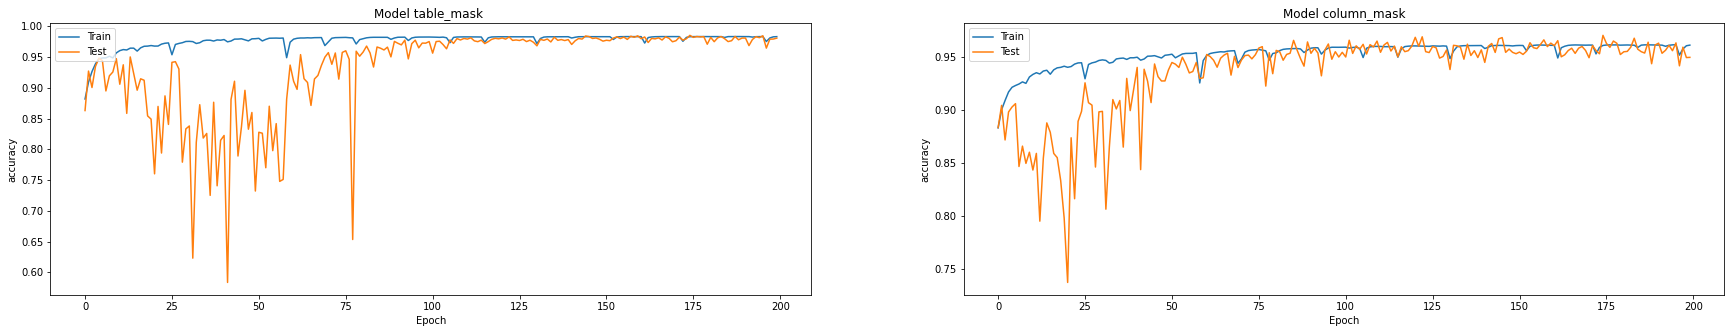

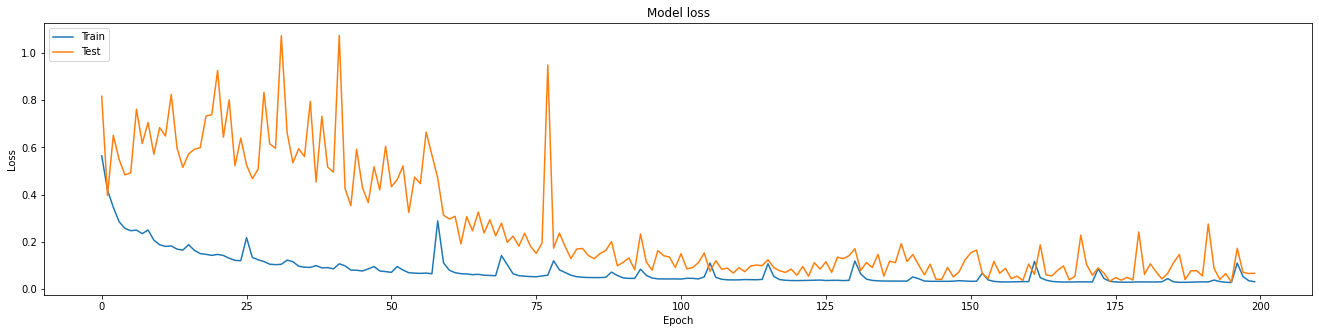

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(model_history.history['table_mask_accuracy'])
plt.plot(model_history.history['val_table_mask_accuracy'])
plt.title('Model table_mask ')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(model_history.history['column_mask_accuracy'])
plt.plot(model_history.history['val_column_mask_accuracy'])
plt.title('Model column_mask')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(50, 5))
plt.subplot(122)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [5]:
def masks(table_mask, column_mask):
  table_mask = tf.argmax(table_mask, axis=-1)
  table_mask = table_mask[..., tf.newaxis]


  column_mask = tf.argmax(column_mask, axis=-1)
  column_mask = column_mask[..., tf.newaxis]
  return table_mask[0], column_mask[0]

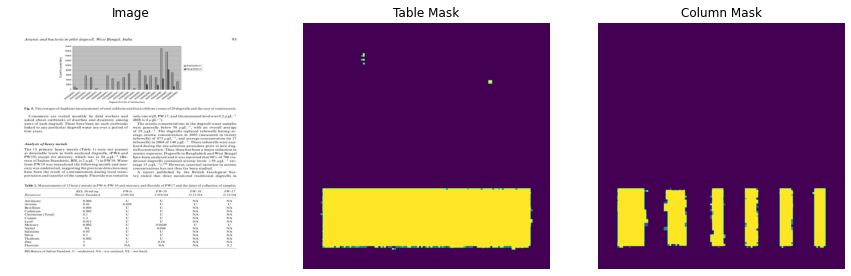

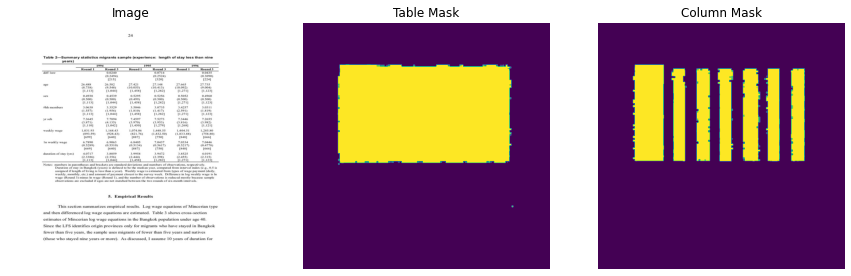

In [ ]:
import numpy as np
number = 2
for image, mask  in test_data.take(number):
  plt.figure(figsize=(15, 15))
  mask1, mask2 = model.predict(image[np.newaxis,:,:,:])
  table_mask, column_mask = masks(mask1, mask2)

  lists = [image, table_mask, column_mask]
  title = ['Image', 'Table Mask', 'Column Mask']         
  for i in range(len(lists)):
    plt.subplot(1, len(lists), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(lists[i]))
    plt.axis('off')
  plt.show()         

# Performance validated by Precision , Recall and F1-score 

In [ ]:
import numpy as np
table , column = list() , list()
predicted_table , predicted_column = list() , list()
for image, mask  in test_data:
  table.append(mask['table_mask'])
  column.append(mask['column_mask'])
  mask1_, mask2_ = model.predict(image[np.newaxis,:,:,:])
  table_mask, column_mask = masks(mask1_, mask2_)
  predicted_table.append(table_mask)
  predicted_column.append(column_mask)


In [ ]:
#https://www.tensorflow.org/api_docs/python/tf/keras/metrics
def recall(table, predicted_table):
  m = tf.keras.metrics.Recall()
  m.update_state(table, predicted_table)
  return m.result().numpy()

def precision(table, predicted_table):
  m = tf.keras.metrics.Precision()
  m.update_state(table, predicted_table)
  return m.result().numpy()  

def result(true , pred):
  Recall = recall(true, pred)
  Precision = precision(true, pred)
  f1 = 2*(Recall * Precision)/(Recall + Precision)
  print(f'Recall is {Recall}')
  print("-"*50)
  print(f'Precision is {Precision}')
  print("-"*50)
  print(f'f1_score is {f1}')


In [ ]:
#checking for table mask
result(table , predicted_table)

Recall is 0.9246924519538879
--------------------------------------------------
Precision is 0.9913131594657898
--------------------------------------------------
f1_score is 0.9568445592566738


In [ ]:
#checking for column mask
result(column , predicted_column)

Recall is 0.7703480124473572
--------------------------------------------------
Precision is 0.9876634478569031
--------------------------------------------------
f1_score is 0.865574093752545


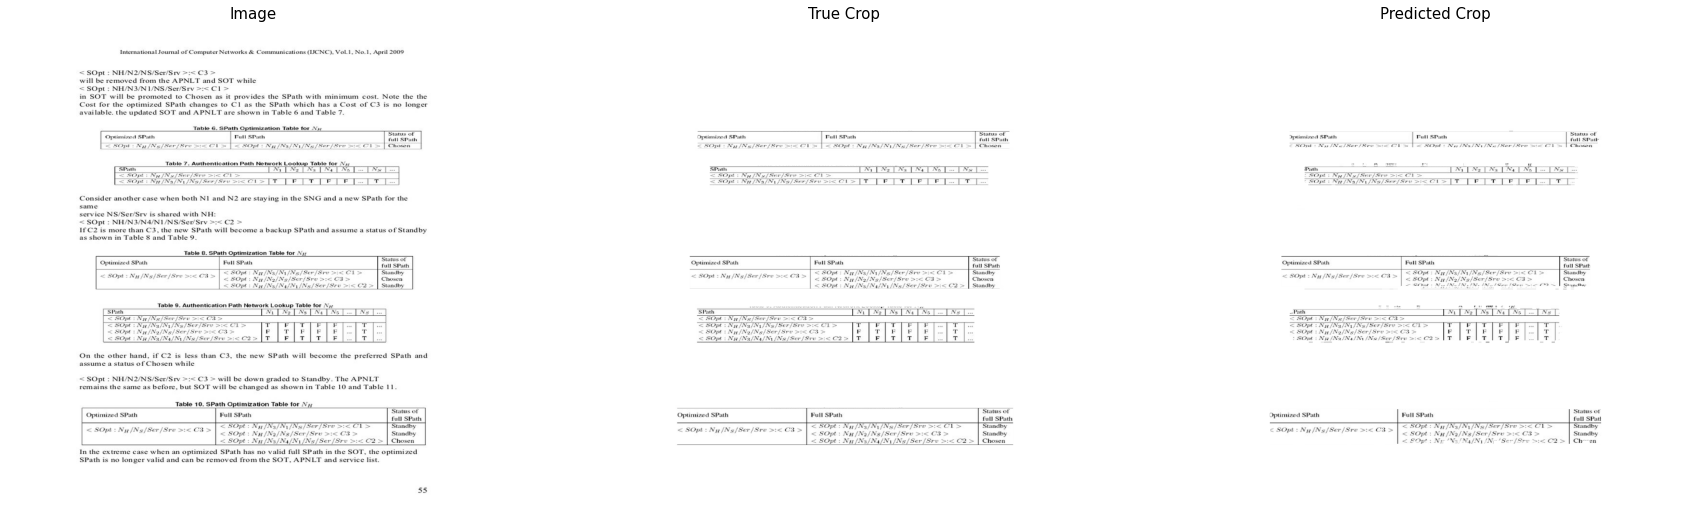

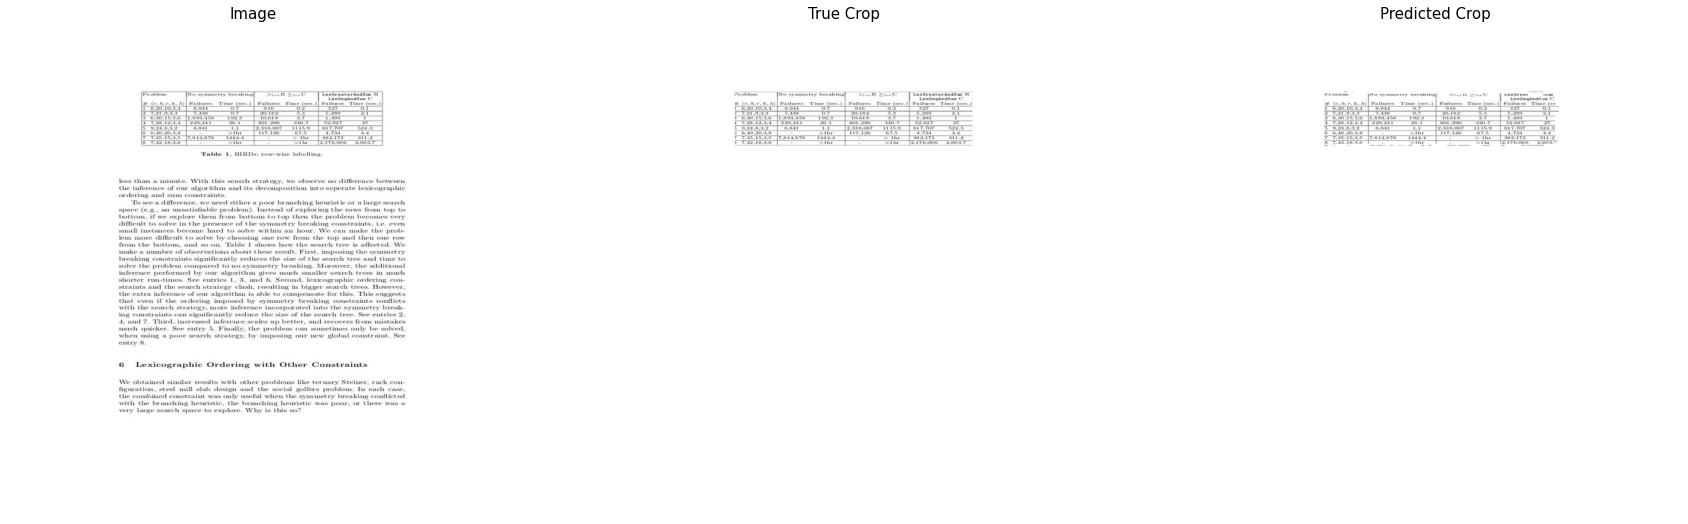

In [ ]:
#randomly comparing predicted output with actual output
number = 2
for image, mask  in test_data.take(number):
  plt.figure(figsize=(30, 50))

  true_table = mask['table_mask']
  true_table=tf.keras.preprocessing.image.array_to_img(true_table)
  true_table = true_table.convert('L')

  true_column = mask['column_mask']
  true_column=tf.keras.preprocessing.image.array_to_img(true_column)
  true_column = true_column.convert('L')


  mask1, mask2 = model.predict(image[np.newaxis,:,:,:])
  table_mask, column_mask = masks(mask1, mask2)

  pred_table = tf.keras.preprocessing.image.array_to_img(table_mask)
  pred_column = tf.keras.preprocessing.image.array_to_img(column_mask)
  pred_table = pred_table.convert('L')
  pred_column = pred_column.convert('L')


  title = ['Image', 'True Crop', 'Predicted Crop']         
  for i in range(len(title)): 
    plt.subplot(1, len(title), i+1)
    if i == 0:
      plt.title(title[i],fontsize=15)
      plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
      plt.axis('off')

    elif i == 1:
      img = tf.keras.preprocessing.image.array_to_img(image)
      img.putalpha(true_table)
      #img.putalpha(true_column)
      plt.title(title[i],fontsize=15)
      plt.imshow(tf.keras.preprocessing.image.array_to_img(img))
      plt.axis('off')

    else:
      img = tf.keras.preprocessing.image.array_to_img(image)
      img.putalpha(pred_table)
      #img.putalpha(pred_column)
      plt.title(title[i],fontsize=15)
      plt.imshow(tf.keras.preprocessing.image.array_to_img(img))  
      plt.axis('off')
  plt.show() 

# converting table image into text

In [ ]:
for image, mask in test_data.take(1):
  mask1, mask2 = model.predict(image[np.newaxis,:,:,:])
  table_mask, column_mask = masks(mask1, mask2)

  im=tf.keras.preprocessing.image.array_to_img(image)
  im.save('/content/content/MyDrive/table_extraction/img/image.bmp')
        
  im=tf.keras.preprocessing.image.array_to_img(table_mask)
  im.save('/content/content/MyDrive/table_extraction/table_mas/table_mask.bmp')
        
  im=tf.keras.preprocessing.image.array_to_img(column_mask)
  im.save('/content/content/MyDrive/table_extraction/column_mas/column_mask.bmp')

In [18]:
#ref: https://stackoverflow.com/questions/65523727/python-image-masking-and-removing-background?noredirect=1&lq=1


# loading image , table mask and column mask from predicted model 
image  = Image.open('/content/content/MyDrive/table_extraction/img/image.bmp')
table_mask = Image.open('/content/content/MyDrive/table_extraction/table_mas/table_mask.bmp')
column_column = Image.open('/content/content/MyDrive/table_extraction/column_mas/column_mask.bmp')

#converting table mask into grayscale
img_mask = img_mask.convert('L')    # grayscale


# add alpha channel    
image.putalpha(table_mask)

#saving image
image.save('output1.png')

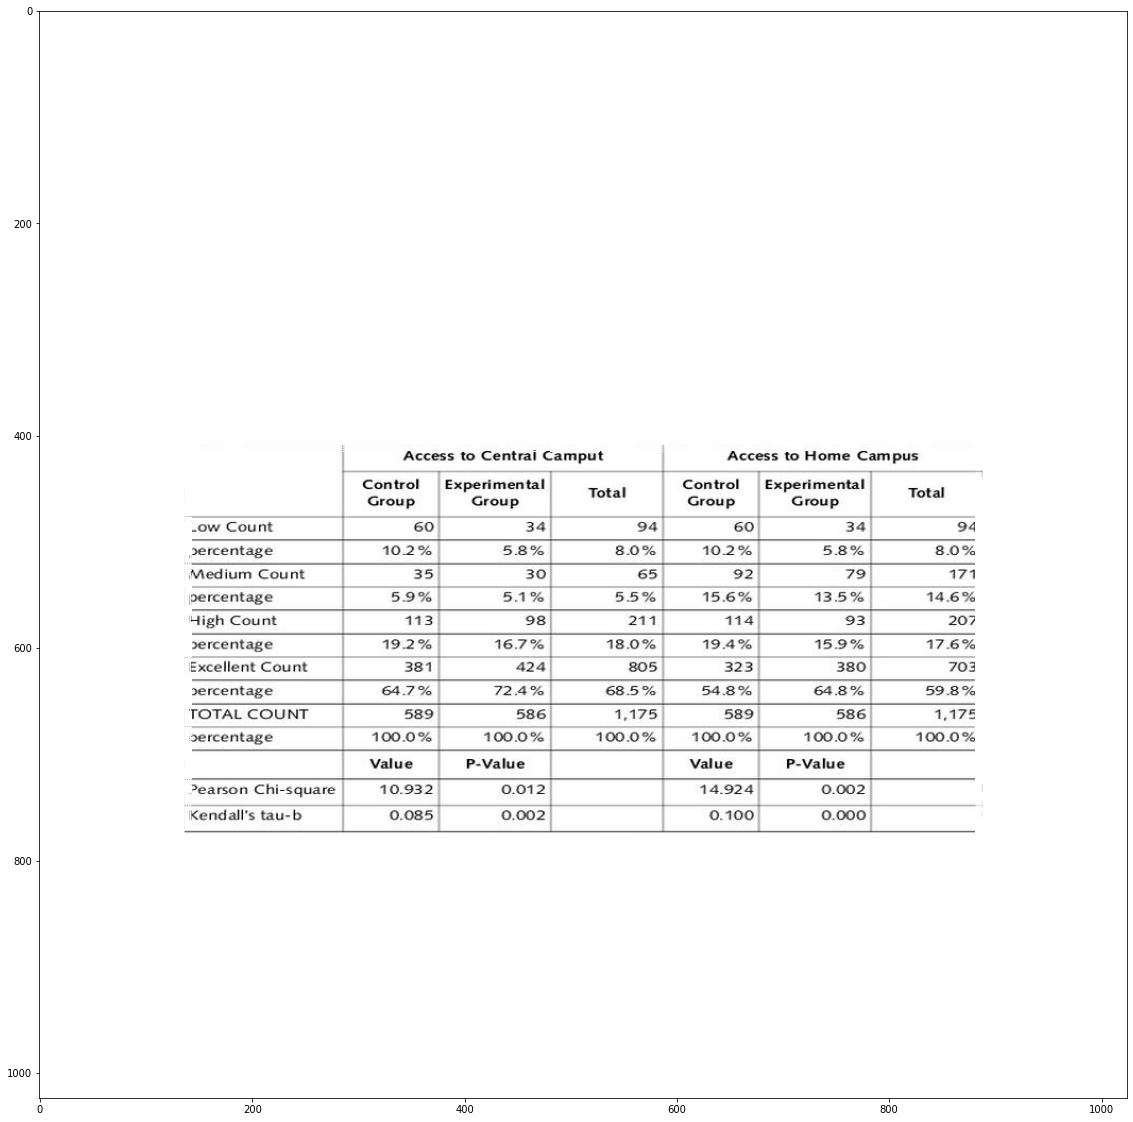

In [19]:
#showing output image 
image = cv2.imread('output1.png',cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(50,20))
plt.imshow(image)

In [1]:
#installing Pillow and pytesseract
!pip install Pillow
!pip install pytesseract

You should consider upgrading via the 'c:\users\dipaktiwari029\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\dipaktiwari029\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [2]:
import pytesseract
from PIL import ImageEnhance, ImageFilter, Image
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe" 

In [5]:
#creating function to input image path and in return we get text file 
def ocr_tesseract(filename):
    text = pytesseract.image_to_string(Image.open(filename))  
    return text

print(ocr_tesseract('output1.png'))

Access to Centrai Camput

Access to Home Campus

 

 

 

 

 

 

 

 

 

 

 

 

 

 

eed ee ee

Tow Count 1 60 34] 34 60] 3a] 34
bercentage [102% 58% 3.0% 102% 58%) 30%
Medium Count | 35 30) 65 92 79| 174
percentage 59% 51% 55% 15.6% 135% | 14.6%
4igh Count 113 98 211 114 93] (207
dercentage 19.2% 16.7% 18.0% 19.4% 15.9% | 17.6%
Excellent Count | 381 424] 805 323 380] 703
Jercentage CAT% 724% | 685% 548% 648% | 598%
TOTAL COUNT 589 586 589 586)
percentage [100.0% 100.0% | 100.0% 100.0% | 100.0%

| value P-value | Value P-value |
Searson Chi-square| 10.932 0.012 74.924 0.002
Kendall's tau-b 0.085 0.002 0.100 0.000)

 

 

 

 

 

